# Theory of Finance Assignment 1 Due: 18.Okt 
Lukas Schreiner, 10 614 782 <br>
Max Tragl, 13 613 419 <br>
Asse, 14 604 201

In [1]:
#Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
%matplotlib inline

### Exercise 1.1 & 1.2

In [2]:
#Load Data
SP500 = pd.read_csv("SP500daily.csv",
                sep         = ",",
                dtype       = {"Date"       : str, 
                               "Open"       : np.float32, 
                               "High"       : np.float32,
                               "Low"        : np.float32,
                               "Close"      : np.float32,
                               "Adj Close"  : np.float32,
                               "Volume"     : np.int32,},
                decimal     = ".",
                engine      = "python")

In [3]:
#Adjust Date format
SP500['Date']  = pd.to_datetime(SP500['Date'])
SP500['Week']  = SP500['Date'].dt.week
SP500['Month'] = SP500['Date'].dt.month
SP500['Year']  = SP500['Date'].dt.year

#Calculate Returns and Log returns
SP500['Return'] = SP500['Adj Close'].pct_change()
SP500['Log Return'] = np.log(SP500['Adj Close']) - np.log(SP500['Adj Close'].shift(1))

#Rearrage Columns
cols = ['Date', 'Week', 'Month', 'Year', 
        'Open', 'High', 'Low', 'Close', 
        'Adj Close', 'Volume',  'Return', 
        'Log Return']

SP500 = SP500[cols].set_index('Date')

SP500.head()

,Week,Month,Year,Open,High,Low,Close,Adj Close,Volume,Return,Log Return
Date,,,,,,,,,,,
1950-01-03,1,1,1950,16.66,16.66,16.66,16.66,16.66,1260000,NaN,NaN
1950-01-04,1,1,1950,16.85,16.85,16.85,16.85,16.85,1890000,0.011405,0.011340
1950-01-05,1,1,1950,16.93,16.93,16.93,16.93,16.93,2550000,0.004748,0.004737
1950-01-06,1,1,1950,16.98,16.98,16.98,16.98,16.98,2010000,0.002953,0.002949
1950-01-09,2,1,1950,17.08,17.08,17.08,17.08,17.08,2520000,0.005889,0.005872


In [4]:
def calculate_return_over_period(time_window, time_horizon = ['1950-01-03','2017-12-27']): 
    
    value_endofperiod = []
    log_returns_period = []
    period = 0

    for index, row in SP500[time_horizon[0]:time_horizon[1]].iterrows():
        if row[time_window] != period:    
            value_endofperiod.append(row['Close']) 
            period = row[time_window]

    #The closing value of a period is the opening value of the next period
    for i in range(1,len(value_endofperiod)):
        log_returns_period.append(np.log(value_endofperiod[i] / value_endofperiod[i-1]))
    
    return log_returns_period

In [5]:
log_mean_daily = np.mean(SP500['Log Return'])

log_returns_weekly  = calculate_return_over_period('Week')

log_returns_monthly = calculate_return_over_period('Month')

log_returns_yearly  = calculate_return_over_period('Year')

In [6]:
output = {'Daily':   [(np.mean(SP500['Log Return']) *100),(np.std(SP500['Log Return']) *100), (np.var(SP500['Log Return']) *100)], 
          'Weekly':  [(np.mean(log_returns_weekly)  *100),(np.std(log_returns_weekly)  *100), (np.var(log_returns_weekly)  *100)],
          'Monthly': [(np.mean(log_returns_monthly) *100),(np.std(log_returns_monthly) *100), (np.var(log_returns_monthly) *100)], 
          'Yearly':  [(np.mean(log_returns_yearly)  *100),(np.std(log_returns_yearly)  *100), (np.var(log_returns_yearly)  *100)]} 

ouput_table = pd.DataFrame(data = output, index = ['Mean', 'Std','Variance' ])
ouput_table.columns.name = 'in %'
ouput_table

in %,Daily,Weekly,Monthly,Yearly
Mean,0.029713,0.143241,0.621640,7.327088
Std,0.964509,2.271903,4.166587,15.716742
Variance,0.009303,0.051615,0.173604,2.470160


### Exercise 1.3

In [7]:
#Initial Investment = 1
init_inv = 1

value_inv_today = init_inv * (SP500['Return'] + 1).cumprod().iloc[-1]
print("Value of 1 USD Investment today: %.2f USD" % round(value_inv_today,2)) 

Value of 1 USD Investment today: 161.32 USD


### Exercise 1.4

In [8]:
#Import Data
TBill = pd.read_csv("DTB3.csv",
                sep         = ",",
                dtype       = {"DATE" : str, 
                               "DTB3" : str,
                              },
                decimal     = ".",
                engine      = "python")

# Correct for annulization
TBill['Log TB3'] = np.log(pd.to_numeric(TBill['DTB3'], errors = 'coerce')/100/365 + 1)
TBill['DATE'] = pd.to_datetime(TBill['DATE'])

#Handle NAN values through interpolation
TBill['Log TB3'] = TBill['Log TB3'].interpolate()
print("Number of NAN Values in TB3: ", TBill['Log TB3'].isna().sum())

#Merge Datasets
SP500 = SP500.join(TBill.set_index("DATE"))
SP500[["Close", "Log Return" ,"Log TB3"]].tail(5)

#writer = pd.ExcelWriter('output.xlsx')
#df.to_excel(writer,'Sheet1')
#writer.save()

Number of NAN Values in TB3:  0


,Close,Log Return,Log TB3
Date,,,
2017-12-21,2684.570068,0.001984,0.000036
2017-12-22,2683.340088,-0.000459,0.000036
2017-12-26,2680.500000,-0.001059,0.000040
2017-12-27,2682.620117,0.000791,0.000039
2017-12-28,2687.540039,0.001832,0.000038


In [9]:
risk_free = np.mean(SP500["Log TB3"]['2000-01-03':'2017-12-27'])

cum_log_returns     = (SP500['Log Return']['2000-01-03':'2017-12-27'] + 1).cumprod().iloc[-1]
cum_log_rf_returns  = (SP500['Log TB3']['2000-01-03':'2017-12-27'] + 1).cumprod().iloc[-1]

cum_excess_return = cum_log_returns - cum_log_rf_returns

print("The excess return over the period is %.4f percent" % (cum_excess_return*100))

The excess return over the period is 8.9233 percent


### Exercise 1.5

In [10]:
def sharpe_ratio(return_data, risk_free):
    
    excess_return  = [r - risk_free for r in return_data]
    
    avg_excess_ret = np.sum(excess_return) / len(excess_return)
    
    sharpe_ratio   = avg_excess_ret / np.var(excess_return)
    
    return sharpe_ratio

log_ret_weekly2    = calculate_return_over_period("Week",['2000-01-03','2017-12-27'])

log_ret_monthly2   = calculate_return_over_period("Month",['2000-01-03','2017-12-27'])

log_ret_yearly2    = calculate_return_over_period("Year",['2000-01-03','2017-12-27'])

In [11]:
shr_daily     = sharpe_ratio(SP500["Log Return"]['2000-01-03':'2017-12-27'], risk_free)

shr_weekly    = sharpe_ratio(log_ret_weekly2, risk_free)

shr_monthly   = sharpe_ratio(log_ret_monthly2, risk_free)

shr_yearly    = sharpe_ratio(log_ret_yearly2, risk_free)

sharpe = pd.DataFrame({'Daily'   : [shr_daily],
                       'Weekly'  : [shr_weekly], 
                       'Monthly' : [shr_monthly],
                       'Yearly'  : [shr_yearly]}, 
                       index = ['Sharpe Ratio'])

sharpe.columns.name = '.'
sharpe

.,Daily,Weekly,Monthly,Yearly
Sharpe Ratio,0.607171,0.937168,1.242186,0.921079


### Exercise 2.1

In [12]:
#Import Data
stock_data = pd.read_excel('PS1-2_Studynet.xlsx')

#Clean Header
stock_data.columns = stock_data.columns.str.replace("Equity", "")
stock_data.columns = stock_data.columns.str.replace("SE", "")
stock_data.columns = stock_data.columns.str.replace("SW", "")
stock_data.columns = stock_data.columns.str.replace(" ", "")

In [13]:
stock_cols = stock_data.columns
stock_data = stock_data.set_index('Date')
stock_data.head()

,ABBN,SPSN,SIKA,LOGN,PGHN,DOKA,ZURN,AMS,GIVN,SOON,...,LONN,CLN,NESN,ARYN,HELN,GEBN,FHZN,ROG,PSPN,UBSG
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-01,19.94,56.57,26.92,17.93,130.6,249.10,226.5,4.53,826.5,125.5,...,67.62,12.146,50.20,38.074,320.75,183.5,62.25,175.8,58.50,16.05
2010-01-08,21.05,57.69,27.75,18.65,138.2,257.25,232.4,5.10,863.0,128.9,...,73.13,12.573,49.11,38.667,334.75,185.3,62.35,178.5,61.30,17.21
2010-01-15,20.61,59.00,27.37,18.65,132.0,257.25,233.0,5.23,868.5,132.1,...,75.86,12.513,49.12,39.407,331.00,191.2,60.70,184.4,61.90,16.10
2010-01-22,19.26,58.22,26.40,18.44,131.4,263.00,226.9,5.59,873.0,133.6,...,73.08,11.609,50.55,40.988,326.50,189.2,58.50,184.8,60.60,14.93
2010-01-29,19.45,58.22,27.18,18.13,132.0,266.25,227.6,5.60,869.5,131.9,...,70.07,11.688,50.50,41.580,331.75,187.7,60.00,178.5,60.95,14.03


Text(0.5,1,'Prices / LISN')

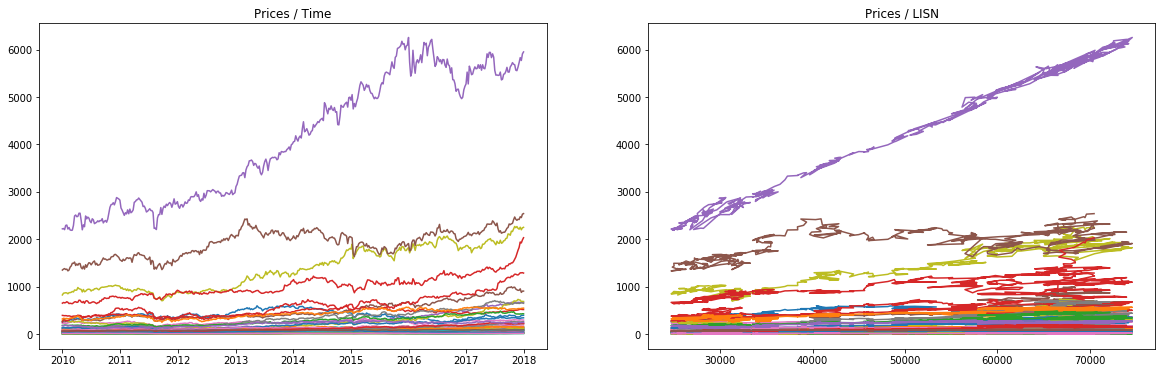

In [14]:
figure_1 = plt.figure(figsize=(20,6))
chart_1  = figure_1.add_subplot(121)
chart_2  = figure_1.add_subplot(122)

for i in range(1,len(stock_cols)):
    if stock_cols[i] != 'LISN':
        chart_1.plot(stock_data.index, stock_data[stock_cols[i]], label = stock_cols[i])

for i in range(1,len(stock_cols)):
    if stock_cols[i] != 'LISN':
        chart_2.plot(stock_data['LISN'], stock_data[stock_cols[i]], label = stock_cols[i])
        
chart_1.set_title('Prices / Time')
chart_2.set_title('Prices / LISN')

### Exercise 2.2

In [15]:
# The risk free rate
risk_free = np.log(0.27/ 360 + 1)
print(risk_free)

0.0007497188905459742


In [16]:
# log_returns calclates the log return of a given dataset and returns a dataframe with only its log returns

def log_returns(dataset):
    
    cols = dataset.columns
    
    for i in range(0,len(cols)):
        
        #Calculate Log returns
        dataset['LG_' + cols[i]] = np.log(dataset.loc[:,(cols[i])]) - np.log(dataset.loc[:,(cols[i])].shift(1))
        
        #Delete Stocks Prices
        dataset = dataset.drop(cols[i],1)
        
        #Delete first row (contains 'NaN')
        lg_dataset = dataset.iloc[1:]
        
    return lg_dataset

In [17]:
#Selected Stocks
selected_stocks_cols = ['CSGN', 'UBSG', 'ABBN', 'NESN', 'NOVN', 'CFR']

selected_stocks = stock_data.loc[:,(selected_stocks_cols)]

lg_selected_stocks = log_returns(selected_stocks)

lg_selected_stocks['Risk_Free'] = risk_free
lg_selected_stocks.head()

,LG_CSGN,LG_UBSG,LG_ABBN,LG_NESN,LG_NOVN,LG_CFR,Risk_Free
Date,,,,,,,
2010-01-08,0.090500,0.069782,0.054173,-0.021952,-0.048967,0.048886,0.00075
2010-01-15,-0.075005,-0.066671,-0.021124,0.000204,0.006485,0.000274,0.00075
2010-01-22,-0.099807,-0.075447,-0.067746,0.028697,0.038048,-0.041988,0.00075
2010-01-29,-0.010898,-0.062175,0.009817,-0.000990,0.010610,0.034283,0.00075
2010-02-05,-0.054067,-0.010749,-0.034522,-0.043507,0.005263,-0.035713,0.00075


In [18]:
np.mean(lg_selected_stocks)

LG_CSGN     -0.002376
LG_UBSG      0.000267
LG_ABBN      0.000647
LG_NESN      0.001229
LG_NOVN      0.000905
LG_CFR       0.002238
Risk_Free    0.000750
dtype: float64

In [19]:
#Expected Log Returns for selected stocks with and without rf
sel_expretrf  = np.mean(lg_selected_stocks)
sel_expret    = np.mean(lg_selected_stocks.iloc[:,0:6])
#print(expected_returns)

#Covariance matrix rounded to 6 decimals for selected stocks with and without rf
sel_covmatrf = np.round(np.cov(lg_selected_stocks.values.T[:]),6)
sel_covmat   = np.round(np.cov(lg_selected_stocks.iloc[:,0:6].values.T[:]),6)
#print(sel_covmatrf)

In [20]:
def portfolio_ret(w, expected_returns):
    return (np.sum(expected_returns * w)*100)

def portfolio_vol(w, cov_mat):
    return ((np.dot(np.dot(w.T,cov_mat), w)*100)**2)

def neg_sharpe_ratio(w, expected_returns, cov_mat, risk_free):
    pstd = np.sqrt(portfolio_vol(w, cov_mat))
    preturn = portfolio_ret(w, expected_returns)
    
    return -(preturn - risk_free) / pstd

In [21]:
#Calculate the minimum variance portfolio without riskless asset
def minvar(ret, expected_returns, cov_mat):
    
    num_assets = len(expected_returns)
    
    args = (cov_mat)
    
    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1}, 
                   {'type': 'eq', 'fun': lambda w: portfolio_ret(w , expected_returns) - ret})
    
    result = minimize(portfolio_vol, num_assets*[1./num_assets,], args = args,
                        method = 'SLSQP', constraints = constraints)
    
    mu  = portfolio_ret(result.x, expected_returns)
    var = portfolio_vol(result.x, cov_mat)

    return mu, var, result.x

In [22]:
#Calculate random portfolios
def random_portfolios(number, exp_ret, cov_mat):
    #Random Portfolios (rp)
    rp_ret = []
    rp_std = []

    for i in range(0,number):
        
        #Choose Random weights and calculate repective mean return (rp_ret) and standard deviations (rp_std)
        rn = np.random.normal(0,1,len(exp_ret))
        rp_w = rn / np.sum(rn)

        rp_ret.append(portfolio_ret(rp_w, exp_ret))
        rp_std.append(np.sqrt(portfolio_vol(rp_w, cov_mat)))

    return rp_ret, rp_std

In [23]:
#Calculate the mean variance frontier without riskless asset
def mv_frontier(exp_ret, cov_mat):
    
    minvar_ret = []
    minvar_std = []
    minvar_wg  = []
    mu_star = 0
    
    for i in range(0,60):
        
        mu, var, w = minvar(mu_star, exp_ret, cov_mat)

        minvar_ret.append(round(mu,6))
        minvar_std.append(np.sqrt(var))
        minvar_wg.append(w)

        mu_star += 0.01
        
    return minvar_ret, minvar_std, minvar_wg

In [24]:
#Calculate the tanget portfolio for a given set of portfolios
def tangecy_portfolio(expected_returns, cov_mat, risk_free):
    
    num_assets = len(expected_returns)
    
    args = (expected_returns, cov_mat, risk_free)
    
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
        
    result = minimize(neg_sharpe_ratio, num_assets*[1./num_assets,], args=args,
                        method = 'SLSQP', constraints=constraints)
    
    tang_mu  = portfolio_ret(result.x, expected_returns)
    tang_std = np.sqrt(portfolio_vol(result.x, cov_mat))
    
    return tang_mu, tang_std, result.x

### Excesise 2.2

In [25]:
#Calculate the MV Frontier for selected stocks
sel_minvar_ret, sel_minvar_std, minvar_wg             = mv_frontier(sel_expret, sel_covmat)

#Calculate the Tangency Portfolio for selected stocks
sel_tang_mu, sel_tang_std, _ = tangecy_portfolio(sel_expret, sel_covmat, risk_free)

#Calculate Radom Portfolios
sel_rp_ret, sel_rp_std = random_portfolios(1000, sel_expret, sel_covmat)

#Min Var Frontier w/ risk free asset
sel_minvar_stdrf   = np.linspace(0, sel_minvar_std[59], len(sel_minvar_std[:60]))
sel_minvar_retrf   = np.divide(np.dot(sel_minvar_stdrf,sel_tang_mu),sel_tang_std) + risk_free
sel_minvar_wgrf    = 1 - sel_minvar_retrf / sel_tang_mu

In [26]:
portfolios = pd.DataFrame({'1%'    : [sel_minvar_retrf[0] ,sel_minvar_stdrf[0], sel_minvar_wgrf[0]],
                           '10%'   : [sel_minvar_retrf[1] ,sel_minvar_stdrf[1], sel_minvar_wgrf[1]], 
                           '30%'   : [sel_minvar_retrf[30],sel_minvar_stdrf[30],sel_minvar_wgrf[30]],
                           '39%'   : [sel_minvar_retrf[40],sel_minvar_stdrf[40],sel_minvar_wgrf[40]]}, 
                            index = ['Exp Ret', 'Std', 'Weight rf'])

portfolios.columns.name = 'Expected Return'
portfolios

Expected Return,1%,10%,30%,39%
Exp Ret,0.000750,0.017931,0.516195,0.688010
Std,0.000000,0.003576,0.107272,0.143030
Weight rf,0.996986,0.927917,-1.075092,-1.765784


### Excesise 2.3

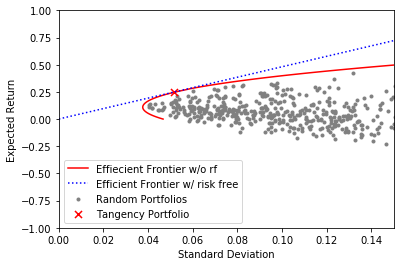

In [27]:
#Plot the MV Frontier for selected stocks
chart_3 = plt.scatter(sel_rp_std, sel_rp_ret, marker = '.', color = 'grey', label = 'Random Portfolios')

chart_3 = plt.plot(sel_minvar_std, sel_minvar_ret, color = 'red', label = 'Effiecient Frontier w/o rf')
chart_4 = plt.plot(sel_minvar_stdrf, sel_minvar_retrf, color = 'blue', label = 'Efficient Frontier w/ risk free' , linestyle = ':')

chart_3 = plt.scatter([sel_tang_std], [sel_tang_mu], color = 'red',marker = 'x', label = 'Tangency Portfolio',  s=50)

chart_3 = plt.legend()

axes = plt.gca()
axes.set_xlim([0,0.15])
axes.set_ylim([-1,1])

chart_3 = plt.xlabel('Standard Deviation')
chart_3 = plt.ylabel('Expected Return')

chart_3 = plt.show()

### Exercise 2.4

In [28]:
lg_stock_data = log_returns(stock_data)
lg_stock_data['Risk_Free'] = risk_free
lg_stock_data.head()

,LG_ABBN,LG_SPSN,LG_SIKA,LG_LOGN,LG_PGHN,LG_DOKA,LG_ZURN,LG_AMS,LG_GIVN,LG_SOON,...,LG_CLN,LG_NESN,LG_ARYN,LG_HELN,LG_GEBN,LG_FHZN,LG_ROG,LG_PSPN,LG_UBSG,Risk_Free
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-08,0.054173,0.019605,0.030366,0.039371,0.056563,0.032194,0.025715,0.118519,0.043215,0.026731,...,0.034552,-0.021952,0.015455,0.042722,0.009761,0.001605,0.015242,0.046753,0.069782,0.00075
2010-01-15,-0.021124,0.022454,-0.013788,0.000000,-0.045900,0.000000,0.002578,0.025171,0.006353,0.024522,...,-0.004784,0.000204,0.018957,-0.011266,0.031344,-0.026820,0.032519,0.009740,-0.066671,0.00075
2010-01-22,-0.067746,-0.013309,-0.036084,-0.011324,-0.004556,0.022106,-0.026529,0.066568,0.005168,0.011291,...,-0.074987,0.028697,0.039336,-0.013688,-0.010515,-0.036917,0.002167,-0.021225,-0.075447,0.00075
2010-01-29,0.009817,0.000000,0.029117,-0.016954,0.004556,0.012282,0.003080,0.001787,-0.004017,-0.012806,...,0.006782,-0.000990,0.014340,0.015952,-0.007960,0.025318,-0.034686,0.005759,-0.062175,0.00075
2010-02-05,-0.034522,-0.004994,-0.047467,-0.079170,-0.007605,-0.020874,0.041735,0.035091,-0.020919,-0.037857,...,-0.043453,-0.043507,-0.028913,-0.029830,-0.019366,-0.005013,-0.049967,0.002458,-0.010749,0.00075


In [29]:
#Expected Log Returns for 48 Stocks
all_expret   = np.mean(lg_stock_data.iloc[:,0:48])
all_expretrf = np.mean(lg_stock_data)

#Covariance matrix for 48 stocks rounded to 6 decimals
all_covmat   = np.round(np.cov(lg_stock_data.iloc[:,0:48].values.T[:]),6)
all_covmatrf = np.round(np.cov(lg_stock_data.values.T[:]),6)

In [30]:
#Calculate the MV Frontier for all stocks
all_minvar_ret, all_minvar_std, all_minvar_wg = mv_frontier(all_expret, all_covmat)

all_minvar_retrf, all_minvar_stdrf, all_minvar_wgrf = mv_frontier(all_expretrf, all_covmatrf)

#Calculate the Tangency Portfolio for selected stocks
all_tang_mu, all_tang_std, _ = tangecy_portfolio(all_expret, all_covmat, risk_free)

#Calculate Radom Portfolios
#all_rp_ret, all_rp_std = random_portfolios(3000, all_expret, all_covmat)

#Min Var Frontier w/ risk free asset
all_minvar_stdrf   = np.linspace(0, all_minvar_std[59], len(all_minvar_std[:60]))
all_minvar_retrf   = np.divide(np.dot(all_minvar_stdrf,all_tang_mu),all_tang_std)
all_minvar_wgrf    = 1 - sel_minvar_retrf / sel_tang_mu

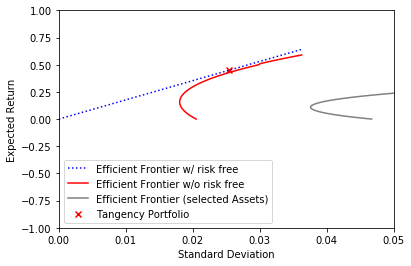

In [31]:
#Plot the MV Frontier for selected stocks
#chart_4 = plt.scatter(all_rp_std, all_rp_ret, marker = '.', color = 'grey',  label = 'Random Portfolios w/ all Assets' )

chart_4 = plt.scatter([all_tang_std], [all_tang_mu], color = 'red', marker = 'x', label = 'Tangency Portfolio')

chart_4 = plt.plot(all_minvar_stdrf, all_minvar_retrf, color = 'blue', label = 'Efficient Frontier w/ risk free' , linestyle = ':')
chart_4 = plt.plot(all_minvar_std, all_minvar_ret, color = 'red', label = 'Efficient Frontier w/o risk free')

chart_4 = plt.plot(sel_minvar_std, sel_minvar_ret, color = 'grey', label = 'Efficient Frontier (selected Assets)')

chart_4 = plt.legend()

axes = plt.gca()
axes.set_xlim([0,0.05])
axes.set_ylim([-1,1])

chart_4 = plt.xlabel('Standard Deviation')
chart_4 = plt.ylabel('Expected Return')

chart_4 = plt.show()

In [33]:
print("Test")

Test
